In [1]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
import obspy
import pickle
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import util
import pandas as pd

In [2]:
root = '/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/' #2018_2021_global_m5/'#'/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m5/'
eq_list = os.listdir(root)

In [3]:
client = Client("IRIS")
# cat = client.get_events(starttime=UTCDateTime("2019-06-26"), endtime=UTCDateTime("2020-06-26"), minlongitude=-179, maxlongitude=-145, minlatitude=42, maxlatitude=71, minmagnitude=5, includearrivals=True)
cat = obspy.read_events('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3_catalog.xml') #2018_2021_global_m5_catalog.xml')
dists = []

do_ypcall: clnt_call: RPC: Timed out
do_ypcall: clnt_call: RPC: Timed out
do_ypcall: clnt_call: RPC: Timed out


In [4]:
eq_with_data = []
cat_with_data = cat.copy()
cat_with_data.clear()
for event in cat:
    eq_name = util.catEventToFileName(event)
    if os.path.isdir(root+eq_name) and os.path.isdir(root+eq_name+'/station_xml_files'):
        eq_with_data.append(eq_name)
        cat_with_data.extend([event])
        

In [70]:
iv2_cumulative = pd.DataFrame({'3.0':[[], [], [], [], [], [], [], []],
                   '3.1':[[], [], [], [], [], [], [], []],
                   '3.2':[[], [], [], [], [], [], [], []],
                   '3.3':[[], [], [], [], [], [], [], []],
                   '3.4':[[], [], [], [], [], [], [], []],
                   '3.5':[[], [], [], [], [], [], [], []],
                   '3.6':[[], [], [], [], [], [], [], []],
                   '3.7':[[], [], [], [], [], [], [], []],
                   '3.8':[[], [], [], [], [], [], [], []],
                   '3.9':[[], [], [], [], [], [], [], []],
                   '4.0':[[], [], [], [], [], [], [], []],
                   '4.1':[[], [], [], [], [], [], [], []],
                   '4.2':[[], [], [], [], [], [], [], []],
                   '4.3':[[], [], [], [], [], [], [], []],
                   '4.4':[[], [], [], [], [], [], [], []],
                   '4.5':[[], [], [], [], [], [], [], []],
                   '4.6':[[], [], [], [], [], [], [], []],
                   '4.7':[[], [], [], [], [], [], [], []],
                   '4.8':[[], [], [], [], [], [], [], []],
                   '4.9':[[], [], [], [], [], [], [], []],
                   '5.0':[[], [], [], [], [], [], [], []],
                   '5.1':[[], [], [], [], [], [], [], []],
                   '5.2':[[], [], [], [], [], [], [], []],
                   '5.3':[[], [], [], [], [], [], [], []],
                   '5.4':[[], [], [], [], [], [], [], []],
                   '5.5':[[], [], [], [], [], [], [], []],
                   '5.6':[[], [], [], [], [], [], [], []],
                   '5.7':[[], [], [], [], [], [], [], []],
                   '5.8':[[], [], [], [], [], [], [], []],
                   '5.9':[[], [], [], [], [], [], [], []],
                   '6.0':[[], [], [], [], [], [], [], []],
                   '6.1':[[], [], [], [], [], [], [], []],
                   '6.2':[[], [], [], [], [], [], [], []],
                   '6.3':[[], [], [], [], [], [], [], []],
                   '6.4':[[], [], [], [], [], [], [], []],
                   '6.5':[[], [], [], [], [], [], [], []],
                   '6.6':[[], [], [], [], [], [], [], []],
                   '6.7':[[], [], [], [], [], [], [], []],
                   '6.8':[[], [], [], [], [], [], [], []],
                   '6.9':[[], [], [], [], [], [], [], []],
                   '7.0':[[], [], [], [], [], [], [], []]})

In [71]:
list_mag = []
list_dist = []
list_iv2_cumulative = []

In [72]:
import warnings;
warnings.filterwarnings('ignore');

In [73]:
eq_no = 0

for eq_name in eq_with_data[eq_no:100]:
    print(str(eq_no) + ' out of '+ str(len(eq_with_data)))# find matching cat event:
    eq_no += 1
    for event in cat_with_data:
        if eq_name == util.catEventToFileName(event):
            cat_entry = event
            break

    eq_lat= cat_entry.origins[0].latitude
    eq_long = cat_entry.origins[0].longitude
    eq_mag = cat_entry.magnitudes[0].mag
    eq_mag_str = "{:.1f}".format(eq_mag)

    data = obspy.read(root+eq_name+'/data/*/*')
    data.interpolate(100, 'lanczos', a = 20)
    inv = obspy.read_inventory(root+eq_name+'/station_xml_files/*')
    #print('data read')
    with open(root+eq_name+'/picks.pkl', 'rb') as f:
        picks = pickle.load(f)
    n_records = 0
    sampling_rate = 100 # get this from tr.stats.sampling_rate
    # sensor_types = self.data_stats['sensor_types'] for automated OOP
    #print('start for')
    for i in range(0, len(data)):  # iterate through all traces
        tr_name = data[i].stats.network+'.'+data[i].stats.station+'.'+data[i].stats.location
        if data[i].stats.channel[2] == 'Z' and tr_name in picks.keys():  # only use vertical components at stations with a pick
            from obspy import UTCDateTime
            IV2 = []
            count = 0
            for i in range(0, len(data)):
                if data[i].stats.channel[2] == 'Z':
                    try:
                        tr = data[i].copy()
                        tr.filter('bandpass', '0.075', '10')
                        station = tr.stats.station
                        station = station.ljust(4)
                        sta_lat = inv.select(network = tr.stats.network, station = tr.stats.station)[0][0].latitude
                        sta_long = inv.select(network = tr.stats.network, station = tr.stats.station)[0][0].longitude
                        distance = np.sqrt((eq_lat - sta_lat)**2 + (eq_long - sta_long)**2) * 110
                        tr_name = tr.stats.network+'.'+tr.stats.station+'.'+tr.stats.location

                        if tr_name in picks.keys() and distance < 200:
                            # load saved parameters

                                tr.remove_response(inv)
                                pick = picks[tr_name]
                                pick = UTCDateTime(picks[tr_name])
                                pick_samples = int(round((UTCDateTime(pick) - tr.stats.starttime)*tr.stats.sampling_rate, 0))                            

                                snr = max(abs(tr.data[pick_samples:500+pick_samples]))/max(abs(tr.data[pick_samples-700:pick_samples-200]))
                                sampling_rate = tr.stats.sampling_rate
                                if snr>10:
                                    start = int((pick - tr.stats.starttime)*sampling_rate)
                                    end = int(start + 3 * sampling_rate)
                                    vel = tr.copy()
                                    v2 = vel.copy()
                                    v2.data = vel.data[start:end]**2
                                    iv2_this = v2.integrate()
                                    #print(iv2_this.data[-1])
                                    #current = iv2_cumulative['3.0'][0]
                                    current = iv2_cumulative[eq_mag_str][int(distance//25)]
                                    current.append(iv2_this.data)
                                    #iv2_cumulative['3.0'][0] = current
                                    iv2_cumulative[eq_mag_str][int(distance//25)] = current
                                    list_iv2_cumulative.append([iv2_this.data])
                                    list_mag.append(eq_mag)
                                    list_dist.append(distance)
                                    counts[eq_mag_str][int(distance//25)] = counts[str(np.floor(eq_mag))][int(distance//25)]  + 1
                    except:
                        continue

0 out of 6077
1 out of 6077
2 out of 6077
3 out of 6077
4 out of 6077
5 out of 6077
6 out of 6077
7 out of 6077
8 out of 6077
9 out of 6077
10 out of 6077
11 out of 6077
12 out of 6077
13 out of 6077
14 out of 6077
15 out of 6077
16 out of 6077
17 out of 6077
18 out of 6077


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

19 out of 6077
20 out of 6077
21 out of 6077


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


22 out of 6077
23 out of 6077


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent.

24 out of 6077


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


25 out of 6077
26 out of 6077
27 out of 6077
28 out of 6077
29 out of 6077
30 out of 6077
31 out of 6077
32 out of 6077
33 out of 6077
34 out of 6077
35 out of 6077
36 out of 6077
37 out of 6077
38 out of 6077
39 out of 6077
40 out of 6077
41 out of 6077
42 out of 6077
43 out of 6077
44 out of 6077
45 out of 6077
46 out of 6077
47 out of 6077
48 out of 6077
49 out of 6077
50 out of 6077


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


51 out of 6077
52 out of 6077
53 out of 6077
54 out of 6077
55 out of 6077
56 out of 6077
57 out of 6077
58 out of 6077


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


59 out of 6077
60 out of 6077
61 out of 6077
62 out of 6077
63 out of 6077
64 out of 6077
65 out of 6077
66 out of 6077
67 out of 6077
68 out of 6077
69 out of 6077
70 out of 6077
71 out of 6077
72 out of 6077
73 out of 6077
74 out of 6077
75 out of 6077
76 out of 6077
77 out of 6077
78 out of 6077
79 out of 6077


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


80 out of 6077
81 out of 6077
82 out of 6077
83 out of 6077
84 out of 6077
85 out of 6077
86 out of 6077
87 out of 6077
88 out of 6077
89 out of 6077
90 out of 6077
91 out of 6077
92 out of 6077
93 out of 6077
94 out of 6077
95 out of 6077
96 out of 6077


 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.
 WARNING (norm_resp): computed and reported sensitivities differ by more than 5 percent. 
	 Execution continuing.


97 out of 6077
98 out of 6077
99 out of 6077


In [29]:
iv2_cumulative['3.0'][0]

[[array([  0.00000000e+00,   3.83090757e-15,   4.66457816e-15,
           5.00280393e-15,   9.86237354e-15,   5.24358654e-14,
           1.37999868e-13,   2.44579984e-13,   4.07491078e-13,
           6.44190303e-13,   9.10412256e-13,   1.29879095e-12,
           1.99440444e-12,   3.31122824e-12,   5.50675867e-12,
           8.42828930e-12,   1.14006987e-11,   1.37907854e-11,
           1.52419791e-11,   1.57553235e-11,   1.59794328e-11,
           1.69060741e-11,   1.90974107e-11,   2.36828150e-11,
           3.16374666e-11,   4.21448420e-11,   5.35098142e-11,
           6.11644884e-11,   6.31853597e-11,   6.41747846e-11,
           6.81551521e-11,   7.32662798e-11,   7.66167578e-11,
           7.95090540e-11,   8.14586045e-11,   8.31443885e-11,
           8.80167193e-11,   9.97661905e-11,   1.15955085e-10,
           1.28654407e-10,   1.37478254e-10,   1.45426542e-10,
           1.51027106e-10,   1.53136258e-10,   1.53824369e-10,
           1.57593200e-10,   1.68079074e-10,   1.843595

In [38]:
ind_iv2[0][0]

0.0

onto row/column plot


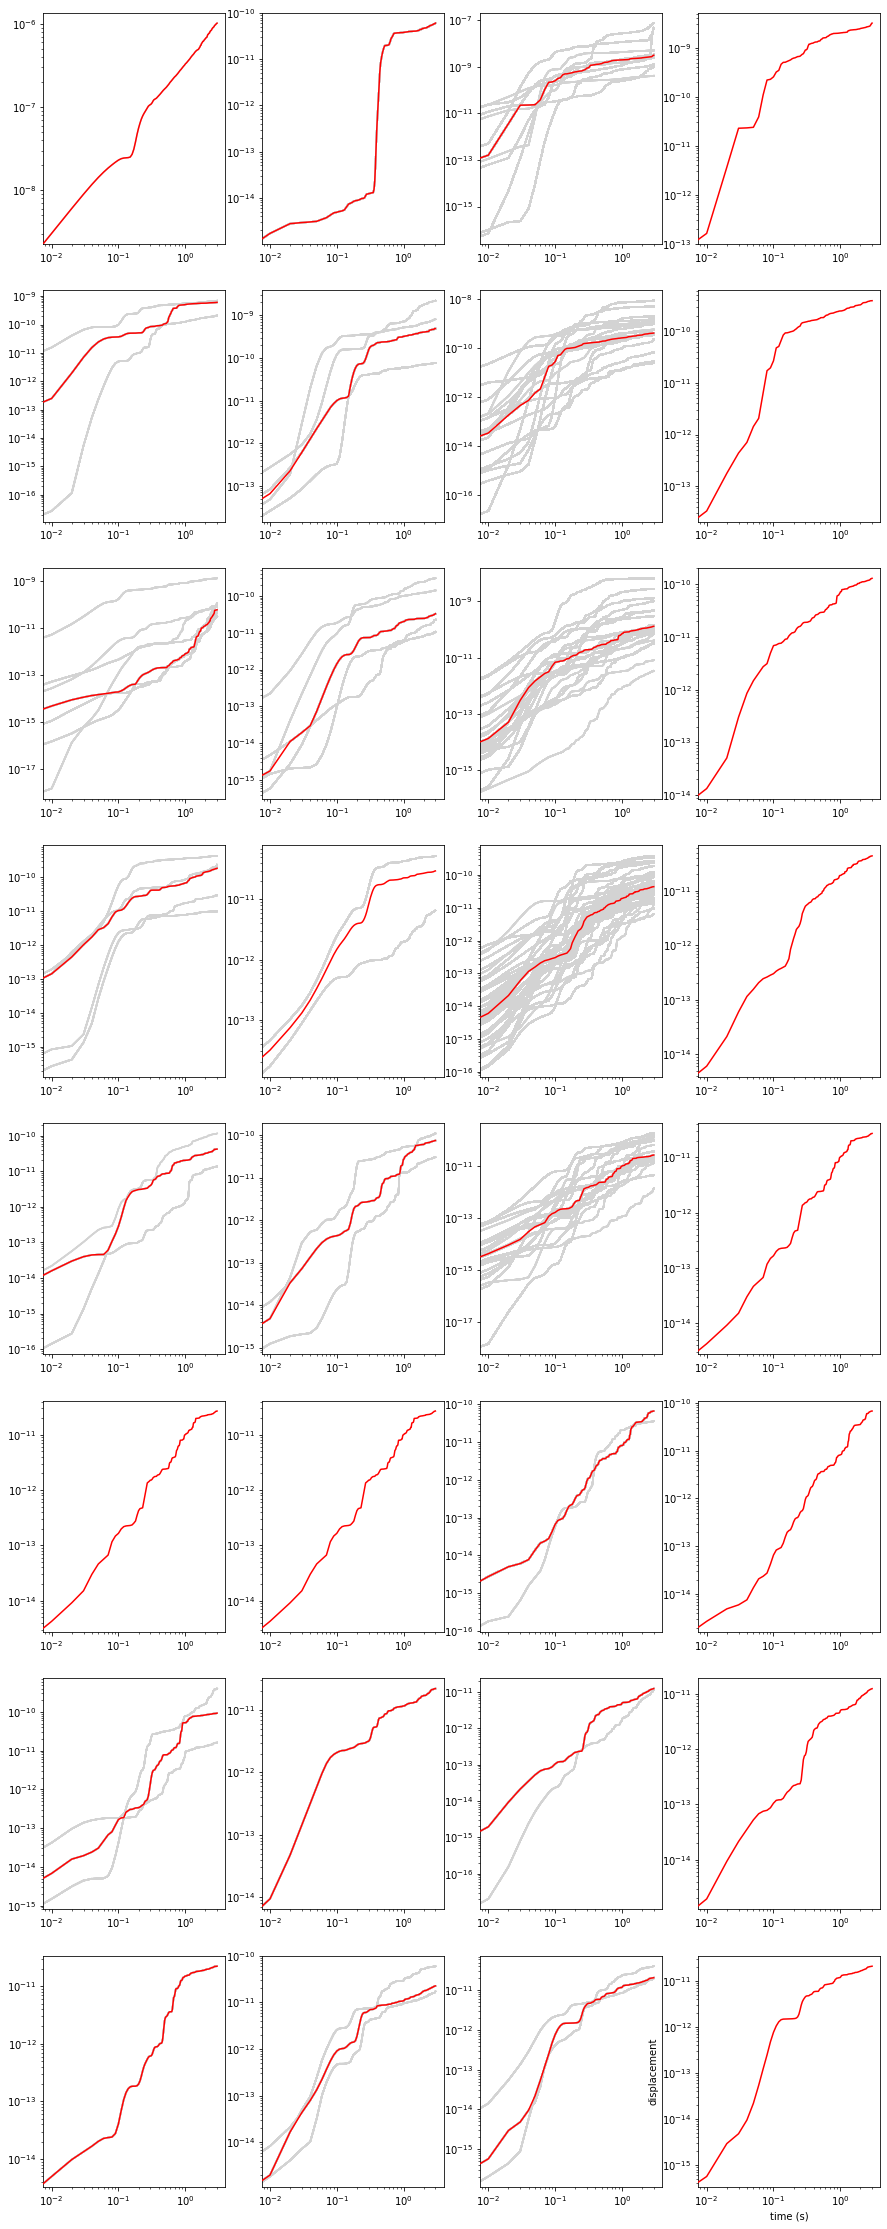

In [75]:
fig, axs = plt.subplots(8, 4, figsize = (15,40)) #df.shape[1]-1
print('onto row/column plot')
row_count = 0
results = [[],[],[],[],[],[],[],[]]
for row in range(8): #rows are distances
    #print('for row')
    col_count = 0
    for column in iv2_cumulative.columns[:4]:
        #print('for column')
        #aad[column][row]=df[column][row]/counts[column][row]#df = sum of absolute displacements
        if len(iv2_cumulative[column][row])>0:
            iv2_ave=np.median(iv2_cumulative[column][row], 0)
        #aad_bin = aad[column][row]
        #axs[row_count][col_count].plot(np.arange(0, 5, 0.01), iv2_cumulative[column][row][:500], zorder = 50, color = 'red')
        for ind_iv2 in iv2_cumulative[column][row]:
            axs[row_count][col_count].plot(np.arange(0, 3, 0.01), ind_iv2[:300], color='lightgrey')
        axs[row_count][col_count].plot(np.arange(0, 3, 0.01), iv2_ave[:300], zorder = 50, color = 'red')
        #axs[row_count][col_count].set_xlim(T_dp[0], T_dp[5])
        #axs[row_count][col_count].set_ylim(0.1, 2)
        axs[row_count][col_count].set_xscale('log')
        axs[row_count][col_count].set_yscale('log') # in log space
        col_count += 1
    row_count += 1


#axs[0][0].set_title('M5-6')
#axs[0][1].set_title('M6-7')
#axs[0][0].set_ylabel('0-25 km')
#axs[1][0].set_ylabel('25-50 km')
#axs[2][0].set_ylabel('50-75 km')
#axs[3][0].set_ylabel('75-100 km')
plt.ylabel('displacement')
plt.xlabel('time (s)')
plt.show()

In [64]:
a = np.concatenate(iv2_cumulative[column][row])
b = []
for i in a:
    b.append(i[1])

In [67]:
np.median(b)

9.3298943124116423e-15

In [58]:
np.median(np.concatenate(iv2_cumulative[column][row]), 0)

array([  0.00000000e+00,   9.32989431e-15,   5.20750891e-14,
         8.29283886e-14,   1.59934544e-13,   1.71108792e-13,
         2.18114628e-13,   5.35744127e-13,   1.06696028e-12,
         1.73795870e-12,   2.20898125e-12,   2.67056754e-12,
         2.76547912e-12,   3.04864982e-12,   3.30479714e-12,
         3.36313322e-12,   3.59754804e-12,   4.75672903e-12,
         6.13994637e-12,   6.63199514e-12,   7.17497857e-12,
         7.67194670e-12,   8.13387930e-12,   8.51361556e-12,
         8.70481586e-12,   8.82422596e-12,   9.11555170e-12,
         9.67946699e-12,   1.04949297e-11,   1.13612575e-11,
         1.19446922e-11,   1.22526752e-11,   1.24395741e-11,
         1.25614358e-11,   1.31386338e-11,   1.40567417e-11,
         1.65221188e-11,   1.94597353e-11,   2.09760626e-11,
         2.25814603e-11,   2.44795685e-11,   2.63639441e-11,
         2.76820751e-11,   2.85358181e-11,   2.95330956e-11,
         3.05515572e-11,   3.13452192e-11,   3.24445649e-11,
         3.41180613e-11,